<a href="https://colab.research.google.com/github/hywkim-private/MNIST_Classifier/blob/main/mnist_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch 
import torchvision
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [32]:
#define hyper parameters 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 20
BATCH_SIZE = 20
LEARNING_RATE = 0.1
VAL_SIZE = 1000
N_CLASS = 10
TEST_SIZE = 1000

In [4]:
#download and define data sets using random split
ds = MNIST(root='./data/', download=True, transform=ToTensor())


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_ds, val_ds, test_ds = random_split(ds, [len(ds)-VAL_SIZE-TEST_SIZE, VAL_SIZE, TEST_SIZE])

In [6]:
#define the dataloader 
train_dl = DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
#this is to validate model with samples from train_ds (since the original set is too large)
train_sample, dump = random_split(train_ds, [VAL_SIZE, len(train_ds)-VAL_SIZE])
train_sample_dl = DataLoader(train_sample, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
"""visualize/check if we have the datasets rights 
for img_set, label_set in train_dl:
    plt.figure(figsize=(5,3))
    plt.imshow(img.permute(1,2,0))"""


'visualize/check if we have the datasets rights \nfor img_set, label_set in train_dl:\n    plt.figure(figsize=(5,3))\n    plt.imshow(img.permute(1,2,0))'

In [26]:

        
#A class to run and evaluate the network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        #A simple network built for testing purposes
        #The architecture for the network has been archieved from A wiki documentation
        self.model = nn.Sequential(
            #w=24
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            #w=12
            nn.MaxPool2d(kernel_size=2, stride=2),
            #w=8
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            #w=4
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(in_features=120, out_features=84, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=N_CLASS, bias=True),
        )
        self.val_loss = []
        self.val_accuracy = []
        self.test_loss = []
        self.test_accuracy = []
        self.train_loss = []
        self.train_accuracy = []
        self.failed_tests_train =[]
        self.failed_tests_valid =[]
        self.failed_tests_test =[]
    #propagate a network for one cycle
    #input: batch of images
    #return: the result value of the network, the loss value
    #NOTE: We will use the cross-entropy validation
    def forward_propagate(self, batch):
        result = self.model(batch).to(DEVICE)
        return result
    
    #backward propoagate and update the parameters using gradients
    #input: output object from the forward_propagate function
    #input: and optimizer object that contains parameters
    def backward_propagate(self, loss, optimizer):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    #an helper function for fit that trains for a single batch
    def fit_batch(self, optimizer):
        error = []
        #take each batch of examples and feed it to the propagation loop
        for index, (image, label) in enumerate(train_dl):
            image, label = image.to(DEVICE), label.to(DEVICE)
            #forward propagate (single iteration)
            result = self.forward_propagate(image)
            loss = F.cross_entropy(result, label)
            #backpropagate
            self.backward_propagate(loss, optimizer)
            error.append(loss)
        return error
    
    
    #train the model and record validation test results
    def fit(self):
        TRAIN_SET = 0
        VALIDATION_SET = 1
        TEST_SET = 2
        #define the optimizer to pass into backward propagation--we will use SGD for the purpose of running semi-batch descent
        optimizer = optim.SGD(self.model.parameters(),lr=LEARNING_RATE)
        #an array of loss and aggregates for train set
        loss_aggregate_t = []
        accuracy_aggregate_t = []
        #an array of loss and aggregates for validation set
        loss_aggregate_v = []
        accuracy_aggregate_v = []
        #an array of loss and aggregates for test set
        loss_aggregate_te = []
        accuracy_aggregate_te = []
        for epoch in range(EPOCHS):
            #empty cuda memory
            if USE_CUDA:
              torch.cuda.empty_cache()
            error = self.fit_batch(optimizer)
            train_accuracy, train_loss, failed_tests_train = self.validate(TRAIN_SET)
            val_accuracy, val_loss, failed_tests_val = self.validate(VALIDATION_SET)
            test_accuracy, test_loss, failed_tests_test = self.validate(TEST_SET)
            loss_aggregate_t.append(train_loss.tolist())
            accuracy_aggregate_t.append(train_accuracy.tolist())
            loss_aggregate_v.append(val_loss.tolist())
            accuracy_aggregate_v.append(val_accuracy.tolist())
            loss_aggregate_te.append(test_loss.tolist())
            accuracy_aggregate_te.append(test_accuracy.tolist())
            print(f"----------Epoch {epoch}----------")
            #print(f"The loss for the TRAINSET is: {train_loss}")
            #print(f"The accuracy of the model on TRAINSET is {train_accuracy}%")
            print(f"The loss for the VALIDSET is: {val_loss}")
            print(f"The accuracy of the model on VALIDSET is {val_accuracy}%")
            print("----------------------------------")
        #update the self parameters
        self.val_loss = loss_aggregate_v
        self.val_accuracy = accuracy_aggregate_v
        self.test_loss = loss_aggregate_te
        self.test_accuracy = accuracy_aggregate_te
        self.train_loss = loss_aggregate_t
        self.train_accuracy = accuracy_aggregate_t
        self.failed_tests_train = failed_tests_train
        self.failed_tests_val = failed_tests_val
        self.failed_tests_test = failed_tests_test
        """validate for a batch of inputs
          def validate_batch(self, batch ):
            image, label = batch
            result = self.forward_propagate(image)
            loss = F.cross_entropy(result, label)
            prediction = torch.argmax(result, dim=1)
            accurate = torch.sum(label == prediction)
            accuracy = (accurate * 100)/ (len(label))
            avg_loss = sum(loss) / len(test_loss)
            return avg_loss, accuracy"""

    #predict the results of the trained model using validation sets
    #if set index ==0, validate for the train set, if set indexx ==1, do it for the validation set 
    def validate(self, set_index):
        #We will initialize with a 0 to avoid divide by zero error
        test_loss = [0]
        #has 1 if the iteration yielded correct data, 0 if not
        correct_or_wrong = 0
        #set which data loader to use
        if set_index == 0:
            set_dl = train_sample_dl
        elif set_index == 1:
            set_dl = val_dl
        elif set_index == 2:
            set_dl = test_dl
        #1xnx2 matrix with predicted fail values and its true labels
        failed_tests = []
        #iterate over the batch of validation datasets and check the accuracy
        for index, (image, label) in enumerate(set_dl):
            image, label = image.to(DEVICE), label.to(DEVICE)
            result = self.forward_propagate(image)
            loss = F.cross_entropy(result, label)
            prediction = torch.argmax(result, dim=1)
            accurate = torch.sum(label == prediction)
            #we will record the failed label and its predicted value
            for i, lab in enumerate(label):
              if lab != prediction[i]:
                failed_tests.append([lab.tolist(), prediction[i].tolist()])
            correct_or_wrong += accurate
            test_loss.append(loss)
        accuracy = (correct_or_wrong * 100)/ ((index+1) * BATCH_SIZE)
        avg_loss = sum(test_loss) / len(test_loss)
        return accuracy, avg_loss, failed_tests
   

In [33]:
torch.cuda.empty_cache()
Net = network().to(DEVICE)
Net.fit()

----------Epoch 0----------
The loss for the VALIDSET is: 0.03446299210190773
The accuracy of the model on VALIDSET is 98.9000015258789%
----------------------------------
----------Epoch 1----------
The loss for the VALIDSET is: 0.02647792175412178
The accuracy of the model on VALIDSET is 99.10000610351562%
----------------------------------
----------Epoch 2----------
The loss for the VALIDSET is: 0.016649732366204262
The accuracy of the model on VALIDSET is 99.4000015258789%
----------------------------------
----------Epoch 3----------
The loss for the VALIDSET is: 0.02372211031615734
The accuracy of the model on VALIDSET is 99.10000610351562%
----------------------------------
----------Epoch 4----------
The loss for the VALIDSET is: 0.020116614177823067
The accuracy of the model on VALIDSET is 99.4000015258789%
----------------------------------
----------Epoch 5----------
The loss for the VALIDSET is: 0.021811947226524353
The accuracy of the model on VALIDSET is 99.6000061035156

In [19]:
#@title
#plot the loss of test and validation set as we train data for each epoch
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, 'b-x', linewidth=4, markersize=12, markerwidth=4)
    plt.plot(val_loss, 'r--o', linewidth=4, markersize=12, markerwidth=4)
    plt.legend(['Train Loss', 'Val Loss'])
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('Epoch')
    

    

In [36]:
class visualization (network): 
  def __init__(self,network):
          super().__init__()

  #A function that extracts weights from the cnn linear function layer 
  def extract_linear_weights(self, layer_index):
    target_layer = self.model[layer_index]
    #initiate extraction only when the layer index indicates a Linear layer
    if isinstance(target_layer, nn.Linear):
      weight = target_layer.weight.data
      print({weight})
    else:
      print("ERROR: Input layer_index of a linear function")
      return
    return weight
  
  
  #Extract the feature map of the input data after it passed through the given layers
  def extract_input_data(self, layer_index, image):
    output = image
    #iterate over the model and run the input image
    for i in range(layer_index):
      target_layer = self.model[i]
      output = target_layer(output)
      output = output.data
      #print(output.shape)
    return output

  #visualize the input feature as it is represented by the convolutional layer
  def visualize_feature(self, image, label, layer_index):
    image = torch.unsqueeze(image, 0)
    output = vis_net.extract_input_data(layer_index, image)

    #the pseudo code for visualizing the feature vectors
    squeezed_output = output.squeeze(0)
    for index, image in enumerate(squeezed_output):
      plt.figure(figsize=(10, 10))
      plt.subplot(4,4, index+1)
      plt.imshow(image, cmap='gray')
      plt.show

  #visualize the linear layer using dimension reduction (tsne)
  def visualize_tsne(self):
    #Compute all the necessary values for the tsne operation
    labels = torch.Tensor
    for index, (image, label) in enumerate(val_dl):
      output = self.extract_input_data(11, image)
      output = np.array(output)
      n,m = output.shape
      if index == 0:
        feature = np.zeros((BATCH_SIZE*len(val_dl)-1,m))
        labels = np.zeros((BATCH_SIZE*len(val_dl)-1,1))
      for i in range(BATCH_SIZE-1):
          feature[BATCH_SIZE*(index) + i,:] = output[i]
          labels[BATCH_SIZE*(index) + i,:] = label[i]
    #run tsne using the sikit learn library
    feature_embedded = TSNE(n_components = 2, n_iter=7000,early_exaggeration=40,perplexity=100,learning_rate=6).fit_transform(feature)
    #plot the representation using scatter plot
    feature_embedded_df = pd.DataFrame(data=feature_embedded, columns=['dim1','dim2'])
    label_df = pd.DataFrame(data=labels,columns=['label'])
    feature_label_df = pd.concat((feature_embedded_df,label_df),axis=1)
    plt.title("T-SNE Representation of the 84 Dimensional Linear Layer")
    sns.scatterplot(data=feature_label_df, hue='label', palette=sns.color_palette("hls", 10),x='dim1', y='dim2',size=6)
  
  #visualize convergence for train, valid, and test sets
  def visualize_convergence(self,val_loss, train_loss, test_loss):
    plt.title("Loss Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    X = np.arange(EPOCHS)
    plt.plot(X,val_loss,label="val_loss") 
    plt.plot(X,train_loss,label="train_loss") 
    plt.plot(X,test_loss,label="test_loss") 
    plt.legend()
    plt.show()


[0.03446299210190773, 0.02647792175412178, 0.016649732366204262, 0.02372211031615734, 0.020116614177823067, 0.021811947226524353, 0.021854504942893982, 0.017783982679247856, 0.02011740207672119, 0.019479045644402504, 0.01741885580122471, 0.017364012077450752, 0.016284838318824768, 0.016471976414322853, 0.01655721664428711, 0.015093924477696419, 0.016185348853468895, 0.01628507487475872, 0.015819275751709938, 0.016184544190764427]


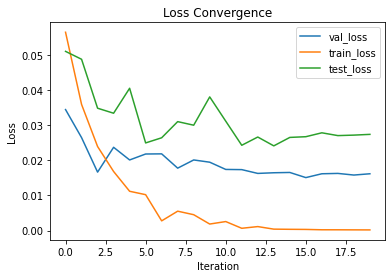

In [35]:
vis_net = visualization(Net)
print(Net.val_loss)
vis_net.visualize_convergence(Net.val_loss, Net.train_loss, Net.test_loss)

In [22]:
print(Net.failed_tests_val)
print(Net.failed_tests_train)
print(Net.failed_tests_test)

[[7, 9], [9, 3], [8, 6], [8, 0], [0, 6], [5, 3]]
[]
[[2, 7], [8, 6], [3, 9], [8, 6], [9, 5], [9, 4], [9, 5], [7, 5], [4, 1], [3, 8]]


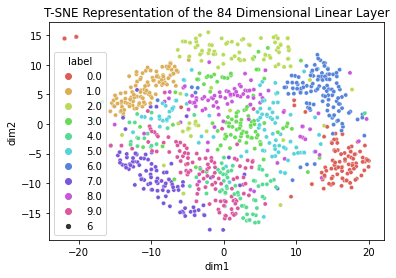

In [37]:
vis_net.visualize_tsne()
  

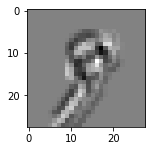

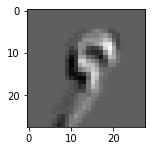

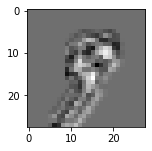

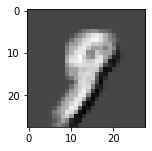

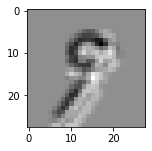

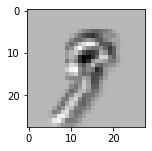

In [52]:
image, label = ds[19]
vis_net.visualize_feature(image, label, 2)

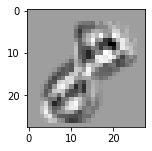

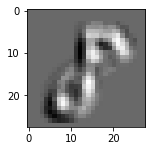

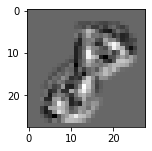

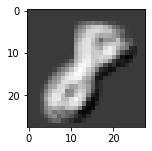

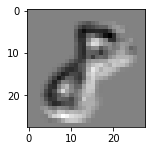

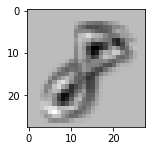

In [64]:
image, label = ds[31]
vis_net.visualize_feature(image, label, 2)